---
<h1 align="center"><span style='font-family:Georgia'> Replicate Informer on the Four ETDataset </span></h1>
    
---

Informer is a deep learning model designed for long sequence time-series forecasting. It was proposed in the paper [Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting](https://arxiv.org/abs/2012.07436) by Haoyi Zhou, et al.

<img width="800" src="Images/informer.png" alt="Informer Architecture" />

---
## Inputs and Outputs
---
##### **Input sequence:**
The input to the Informer model is a time series sequence of fixed length. The sequence contains a set of features, where each feature corresponds to a value measured at a specific time step in the sequence. 
- The length of the input sequence is defined by the `seq_len` hyperparameter.

##### **Output sequence:**

The output of the Informer model is a time series sequence of predicted values, where each value corresponds to a prediction made at a specific time step in the output sequence. 
- The length of the output sequence is defined by the `pred_len` hyperparameter.

---
## Methodology
---
This notebook provide a step-by-step guide for replicating the **Informer** model and training it on the ETDataset (ETTh1, ETTh2, ETTm1, and ETTm2), ensuring accurate reproduction of the models by comparing the notebook results with the official paper results. The main foucs here is to study the *impact of number of prediction length on the performance*. The workflow from the beginning to forcasting is as follows:

### 1.	Data Preprocessing
The data preprocessing steps mentioned in (Zeng, 2023) include normalization with zero-mean, and seasonal-trend decomposition. 
### 2.	Encoding the data (Data Embedding)
The input data is performed by the `enc_embedding` component, which embeds the input time series values, timestamps (temporal embedding), and their positions (postional embeddig) in the sequence. 

- Positional Embedding: Incorporate temporal information by adding a fixed vector representation to each time step to indicate its position, using a combination of sine and cosine signals with differently increasing frequencies to capture unique temporal dynamics.

- Temporal Embedding: Incorporate a vector that represents the time stamp of each data point in the sequence. The purpose of temporal embedding is to provide the model with explicit information about time dynamics, such as the periodicity, trend, or seasonality of the data. 

### 3.	Encoder
A stack of self-attention layers. Each one consists of multiple attention heads that operate in parallel, allowing the model to capture different aspects of the input sequence. Each encoder layer consists of:

- ProbSparse self-attention layer: used to attend to the previous outputs of the encoder. This is an attention mechanism used in Informer that selects the "active" queries rather than the "lazy" queries. It forms a sparse Transformer by the probability distribution, which reduces the computational cost of the attention operation.
- Conv1d layer: used to reduce the dimensionality of the output of the attention layer
- Norm layer. 
- Dropout layer. 

### 4.	Decoder
A stack of self-attention layers. Each decoder layer consists of:

- ProbSparse self-attention layer: used to attend to the previous outputs of the decoder. 
- Cross-attention layer, used to attend to the output of the encoder.
- Conv1d layer: used to reduce the dimensionality of the output of the attention layer.
- Norm layer. 
- Dropout layer. 
    
### 5.	Projection
project the output of the decoder to the desired output size. The projection layer is a linear layer that maps the output of the decoder to a vector of size c (7 in ETDataset), which is the number of output features.



---
## Hyperparameters
---

**Here are the hyperparameters that control the input and output:**

| Parameter | Description | Value |
|---|---|---|
| `args.data` | The name of the dataset to use. | 'ETTh1', 'ETTh2', 'ETTm1', and 'ETTm2'|
| `args.root_path` | The root path of the data file. | `./Datasets/` |
| `args.features` | The type of forecasting task to perform. The options are 'M' (multivariate predict multivariate), 'S' (univariate predict univariate), and 'MS' (multivariate predict univariate). | 'M'|
| `args.target` | The target feature to predict in a univariate or multivariate task. ('HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT')| 'OT' |
| `args.seq_len` | The length of the input sequence to the Informer encoder. | 336|
| `args.pred_len` | The length of the future sequence to be predicted. | [96, 192, 336, 720]|
| `args.padding` | The amount of padding to add to the input sequence, if any. | 0|
| `args.freq` |  | 'h' |
| `args.embed` | The type of time feature encoding to use. The options are 'timeF' (time features encoding), 'fixed' (fixed positional encoding), and 'learned' (learned positional encoding). | 'timeF' |

---------
- **ProbSparse Attention:** 

| Parameter | Description | Value |
|---|---|---|
| `args.attn` | The type of attention used in the encoder. The options are 'prob' (probabilistic sparse attention) and 'full' (full attention). | 'prob' |
| `args.n_heads` | The number of attention heads in the encoder. | 16 |
| `args.factor` | The ProbSparse attention factor. A higher value of factor results in a sparser attention matrix. | 5 |
| `args.dropout` | The dropout probability applied to the attention weights. | 0.1 |
| `args.d_model` | The dimension of the model. | 512 |

---
- **Feedforward Network:** 

| Parameter | Description | Value |
|---|---|---|
| `args.d_ff` | The dimension of the feedforward network. | 2048 |
| `args.activation` | The activation function used in the feedforward network. | 'gelu' |
| `args.dropout` | The dropout probability applied to the attention weights. | 0.1 |

---
- **Mixing Layer:**

The model includes a mixing layer that linearly combines the outputs of the attention heads in the encoder and decoder, which helps to improve the model's performance. Here are the hyperparameters that control the mixing layer:

| Parameter | Description | Value |
|---|---|---|
| `args.mix` | Whether to apply a linear projection to the concatenated outputs of the attention heads. | True |
| `args.d_model` | The dimension of the model. | 512 |

---
**The following are the experiment Hyperparameters.**


| Parameter | Description | Value |
|---|---|---|
| `args.output_attention` | Whether to output attention in ecoder | False |
| `args.use_amp` | Whether to use automatic mixed precision training | False |
| `args.train_only` | Whether to train the model or fine-tune | True |
| `args.train_epochs` | The number of epochs to train for. | 8 |
| `args.batch_size` | The batch size of training input data. | 32 |
| `args.learning_rate` | Learning rate starts from 1e−4, decaying two times smaller every epoch. | 0.0001 |
| `args.lradj` | Learning rate decayed two times smaller every epoch. | 'type1' |
| `args.loss` | Evaluating criteria | `'mse'` |
| `args.patience` | The number of epochs to wait before early stopping. | 3 |
| `args.des` | The description of the experiment. | 'test' |
| `args.itr` | The iteration of the experiment. | 1 |
| `args.model` | The model name | 'informer' |
| `args.checkpoints` | Location of model checkpoints | `'./Checkpoints/Informer_checkpoints'` |


---
# Setup
---

Installs the necessary libraries and dependencies required to run the code in the notebook.

In [1]:
import os
import sys
import random 
import numpy as np
import torch

from exp.exp_Informer import Exp_Informer

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [3]:
"""
    **dotdict function**
    This function is used to convert a dictionary into
    an object whose keys can be accessed as attributes
"""

args = dotdict()

In [4]:
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

**GPU Device Hyperparameters**

In [5]:
######################### Device Hyperparameters  ##########################
args.use_multi_gpu = False
args.num_workers = 0
args.use_gpu = torch.cuda.is_available() 
args.gpu = 0                           # The index of the GPU to use.

**Dataset Hyperparameters**

In [1]:
######################### Dataset Hyperparameters  ##########################

args.data = 'ETTh1'            # dataset name
args.root_path = './Datasets/' # root path of data file
args.data_path = 'ETTh1.csv'   # data file
args.features = 'M'            # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT'             # target feature in S or MS task
args.freq = 'h'                # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.embed = 'timeF'           # time features (date) encoding, options:[timeF, fixed, learned]
args.padding = 0               # the amount of padding to add to the input sequence of the Informer model

NameError: name 'args' is not defined

**Experiment Hyperparameters**



In [7]:
######################### Experiment Hyperparameters  ##########################

args.output_attention = False # whether to output attention in ecoder
args.use_amp = False          # whether to use automatic mixed precision training
args.train_only = True
args.train_epochs = 8         # The number of epochs to train for.
args.batch_size = 32          # The batch size of training input data.
args.learning_rate = 0.0001   # learning rate starts from 1e−4, decaying two times smaller every epoch.
args.lradj = 'type1'          # learning rate decayed two times smaller every epoch.
args.loss = 'mse'             # evaluating criteria
args.patience = 3             # The number of epochs to wait before early stopping.
args.des = 'test'             # The description of the experiment.
args.itr  = 1

args.model = 'informer' 
args.checkpoints = './Checkpoints/Informer_checkpoints' # location of model checkpoints

**Modeling Hyperparameters**

In [8]:
#### [Encoder and Decoder] - ProbSparse Self-attention Hyperparameters  #####
args.attn = 'prob'              # attention used in encoder, options:[prob, full]
args.d_model = 512              # dimension of model (the dimensionality of the input feature vectors, as well as the query, key, and value vectors in each attention head. )
args.n_heads = 16               # num of heads
args.factor = 5                 # probsparse attn factor

args.dropout = 0.1              # dropout
args.d_ff = 2048                # dimension of fcn in model
args.activation = 'gelu'        # activation used in fcn (gelu => Gaussian Error Linear Unit.)
args.mix = True                 # apply a linear projection to the concatenated outputs of the attention heads. 

# concat[start token series(label_len), zero padding series(pred_len)]
args.enc_in = 7                 # encoder input size
args.dec_in = 7                 # decoder input size
args.c_out = 7                  # output size
args.e_layers = 2               # num of encoder layers
args.d_layers = 1               # num of decoder layers

args.seq_len = 336              # input sequence length of DLinear encoder
args.label_len = 48             # start token length of DLinear decoder
args.pred_len = 96              # prediction sequence length


"""
The Distilled Informer architecture is a variant of the standard Informer model that
uses fewer layers and fewer attention heads, making it more computationally efficient.
    (1) 1*3 conv1d with ELU activation
    (2) Max pooling  with strid = 2
""" 
args.distil = True  

"""
0: No embeddings are used (default).
1: All three embeddings are used (value embedding + temporal embedding + positional embedding).
2: Value and temporal embeddings are used.
3: Value and positional embeddings are used.
4: Only value embedding is used.
"""
args.embed_type= 1

---
# Working on ETTh1 Dataset
---

## Trail 1: Informer, Dataset:ETTh1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [9]:
args.pred_len = 96

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 96, 'distil': True, 'embed_type': 1}


In [39]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2785
test 2785
	iters:  100, epoch: 1 | loss: 0.5162737
	speed: 0.6249sec/iter | left time: 1217.8338sec
	iters:  200, epoch: 1 | loss: 0.5029815
	speed: 0.4660sec/iter | left time: 861.6303sec
Epoch: 1 cost time: 132.89297008514404
Epoch: 1, Steps: 256 | Train Loss: 0.5416039 Vali Loss: 1.3748479 Test Loss: 1.0402167
>>> Validation loss decreased (inf --> 1.374848).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4168571
	speed: 1.1681sec/iter | left time: 1977.6303sec
	iters:  200, epoch: 2 | loss: 0.2987680
	speed: 0.5659sec/iter | left time: 901.4552sec
Epoch: 2 cost time: 129.20659589767456
Epoch: 2, Steps: 256 | Train Loss: 0.3955628 Vali Loss: 1.1777896 Test Loss: 1.0761867
>>> Validation loss decreased (1.374848 --> 1.177790).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2491941
	speed: 1.0842sec/iter | left time: 1557.9515sec
	iters:  200, epoch: 3 | loss: 0.2357545
	speed:

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.

### Testing

test 2785
test shape: (2784, 96, 7) (2784, 96, 7)
mae:0.9628899693489075, mse:1.4267077445983887, rmse:1.194448709487915, mape:13.424903869628906, mspe:48977.03515625


<Figure size 1500x500 with 0 Axes>

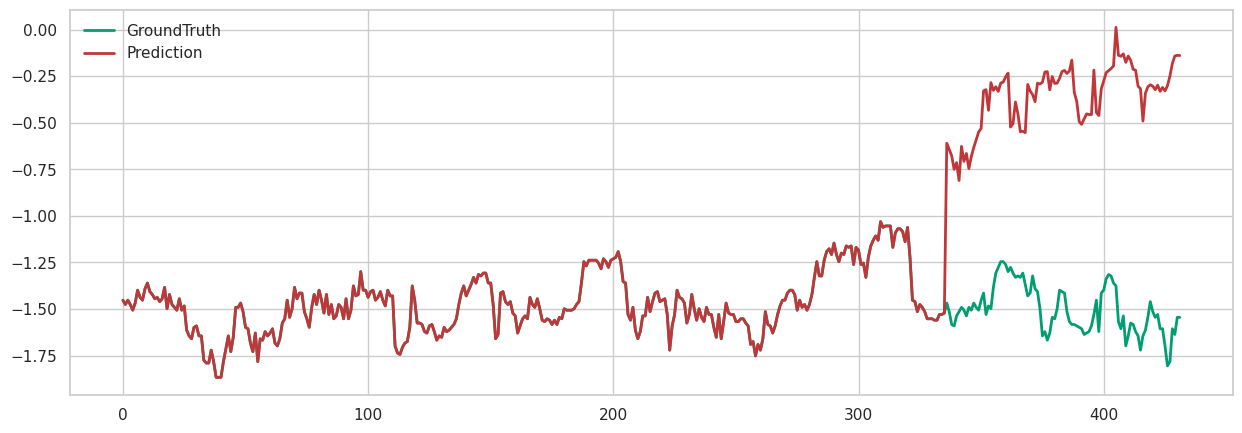

In [44]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: Informer, Dataset:ETTh1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [41]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 192, 'distil': True, 'embed_type': 1}


### Training

In [13]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
val 2689
test 2689
	iters:  100, epoch: 1 | loss: 0.6133929
	speed: 0.6248sec/iter | left time: 1202.6743sec
	iters:  200, epoch: 1 | loss: 0.5127183
	speed: 0.6688sec/iter | left time: 1220.6115sec
Epoch: 1 cost time: 169.16896510124207
Epoch: 1, Steps: 253 | Train Loss: 0.5469503 Vali Loss: 1.5480375 Test Loss: 1.1888574
>>> Validation loss decreased (inf --> 1.548038).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4514236
	speed: 1.5773sec/iter | left time: 2637.2501sec
	iters:  200, epoch: 2 | loss: 0.3691780
	speed: 0.7817sec/iter | left time: 1228.8493sec
Epoch: 2 cost time: 216.6900327205658
Epoch: 2, Steps: 253 | Train Loss: 0.4319976 Vali Loss: 1.3721781 Test Loss: 1.0951765
>>> Validation loss decreased (1.548038 --> 1.372178).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2823824
	speed: 4.6550sec/iter | left time: 6605.4630sec
	iters:  200, epoch: 3 | loss: 0.2941963
	speed

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.

### Testing

test 2689
test shape: (2688, 192, 7) (2688, 192, 7)
mae:1.0440577268600464, mse:1.5364327430725098, rmse:1.2395292520523071, mape:26.94656753540039, mspe:231765.71875


<Figure size 1500x500 with 0 Axes>

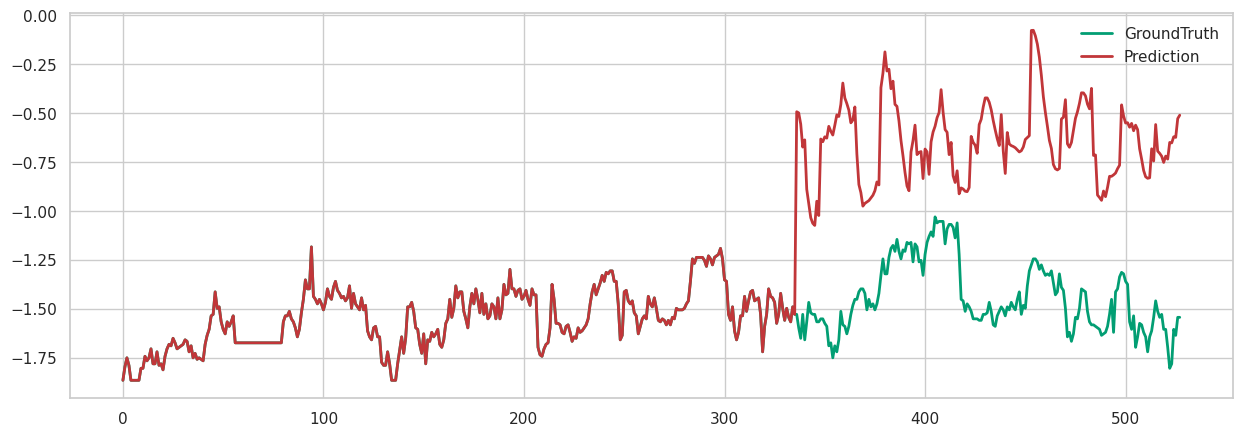

In [14]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: Informer, Dataset:ETTh1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [27]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 336, 'distil': True, 'embed_type': 1}


### Training

In [28]:
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
val 2545
test 2545
	iters:  100, epoch: 1 | loss: 0.5589573
	speed: 1.7040sec/iter | left time: 3225.5957sec
	iters:  200, epoch: 1 | loss: 0.4808396
	speed: 1.6841sec/iter | left time: 3019.5728sec
Epoch: 1 cost time: 422.7042758464813
Epoch: 1, Steps: 249 | Train Loss: 0.5514788 Vali Loss: 1.6976098 Test Loss: 1.1742467
>>> Validation loss decreased (inf --> 1.697610).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4796460
	speed: 5.7789sec/iter | left time: 9500.5872sec
	iters:  200, epoch: 2 | loss: 0.4608472
	speed: 1.8880sec/iter | left time: 2915.1024sec
Epoch: 2 cost time: 459.8090913295746
Epoch: 2, Steps: 249 | Train Loss: 0.4602782 Vali Loss: 1.6485578 Test Loss: 1.2898643
>>> Validation loss decreased (1.697610 --> 1.648558).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.3818017
	speed: 5.0330sec/iter | left time: 7021.0287sec
	iters:  200, epoch: 3 | loss: 0.4358398
	speed:

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.

### Testing

test 2545
test shape: (2528, 336, 7) (2528, 336, 7)
mae:0.8732065558433533, mse:1.1887638568878174, rmse:1.0903044939041138, mape:21.75601577758789, mspe:171106.859375


<Figure size 1500x500 with 0 Axes>

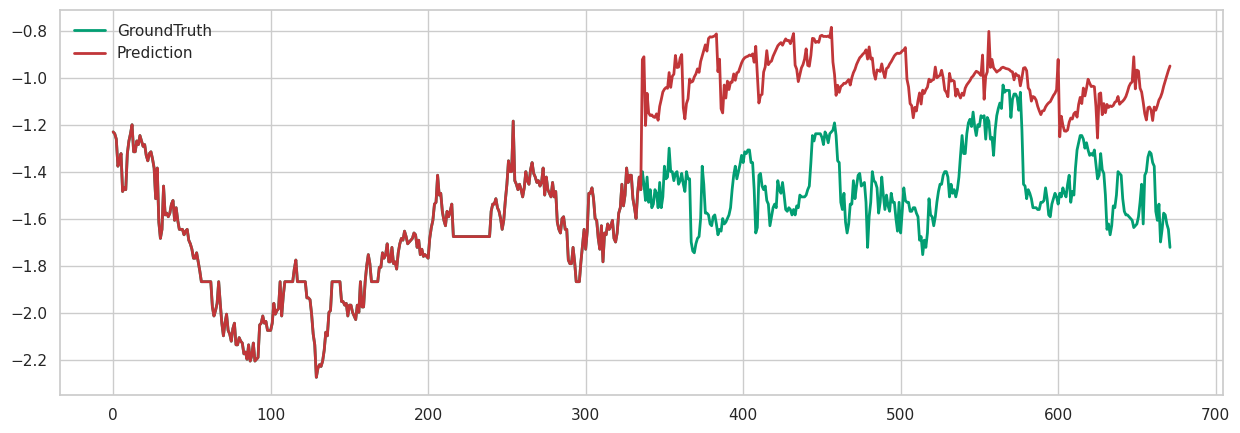

In [29]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: Informer, Dataset:ETTh1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [15]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_720:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [16]:
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
val 2161
test 2161
	iters: 100, epoch: 1 | loss: 0.7466420
	speed: 1.0561s/iter; left time: 1397.2174s
	iters: 200, epoch: 1 | loss: 0.7052477
	speed: 1.1670s/iter; left time: 1427.2754s
Epoch: 1 cost time: 267.50572180747986
Epoch: 1, Steps: 237 | Train Loss: 0.8924379 Vali Loss: 1.7918105 Test Loss: 1.4073195
Validation loss decreased (inf --> 1.791811).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.6966177
	speed: 3.5159s/iter; left time: 3818.3056s
	iters: 200, epoch: 2 | loss: 0.5772589
	speed: 1.5141s/iter; left time: 1492.8951s
Epoch: 2 cost time: 353.6909656524658
Epoch: 2, Steps: 237 | Train Loss: 0.6482369 Vali Loss: 1.9161090 Test Loss: 1.3711313
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.4905525
	speed: 5.0319s/iter; left time: 4272.1064s
	iters: 200, epoch: 3 | loss: 0.5373791
	speed: 1.7840s/iter; left time: 1336.2363s
Epoch: 3 cost time: 423.397679567337

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [17]:
exp.test(setting)
torch.cuda.empty_cache()

test 2161
test shape: (67, 32, 720, 7) (67, 32, 720, 7)
test shape: (2144, 720, 7) (2144, 720, 7)
mse:1.407319188117981, mae:0.976085364818573


---
## Compare Results of `ETTh1`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

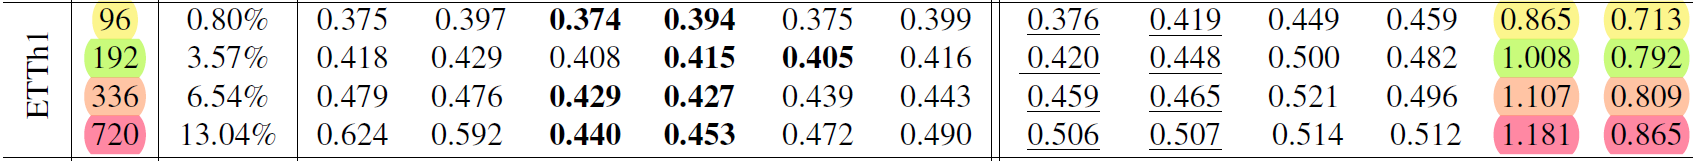

In [18]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTh1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 1.2901318073272705 | 0.913190722465515 |
| 192 | 1.376012921333313 | 0.982631266117096 |
| 336 | 1.1401041746139526 | 0.8656408190727234 |
| 720 | 1.1068990230560303 | 0.8086273074150085 |


---
# Working on ETTh2 Dataset
---

## Trail 1: Informer, Dataset:ETTh2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [33]:
args.data = 'ETTh2'            # dataset name
args.data_path = 'ETTh2.csv'   # data file
args.pred_len = 96
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_96:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [34]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.6133351
	speed: 0.4569s/iter; left time: 656.6079s
	iters: 200, epoch: 1 | loss: 0.5000068
	speed: 0.4630s/iter; left time: 619.0347s
Epoch: 1 cost time: 118.09319233894348
Epoch: 1, Steps: 256 | Train Loss: 0.9679637 Vali Loss: 1.8900480 Test Loss: 3.0697021
Validation loss decreased (inf --> 1.890048).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.7113648
	speed: 1.2461s/iter; left time: 1471.6190s
	iters: 200, epoch: 2 | loss: 0.4740530
	speed: 0.4419s/iter; left time: 477.7255s
Epoch: 2 cost time: 113.49864435195923
Epoch: 2, Steps: 256 | Train Loss: 0.6349976 Vali Loss: 1.9726402 Test Loss: 3.9393003
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.3835185
	speed: 1.1629s/iter; left time: 1075.6757s
	iters: 200, epoch: 3 | loss: 0.4614734
	speed: 0.4262s/iter; left time: 351.6003s
Epoch: 3 cost time: 110.00361967086792


Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [35]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 2785
test shape: (87, 32, 96, 7) (87, 32, 96, 7)
test shape: (2784, 96, 7) (2784, 96, 7)
mse:3.0697035789489746, mae:1.5131016969680786


---
## Trail 2: Informer, Dataset:ETTh2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [22]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_192:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [23]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
val 2689
test 2689
	iters: 100, epoch: 1 | loss: 0.6089929
	speed: 0.8469s/iter; left time: 1201.7064s
	iters: 200, epoch: 1 | loss: 1.2119889
	speed: 0.7171s/iter; left time: 945.8377s
Epoch: 1 cost time: 204.3898983001709
Epoch: 1, Steps: 253 | Train Loss: 0.8617339 Vali Loss: 1.2486205 Test Loss: 3.5046735
Validation loss decreased (inf --> 1.248621).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.5700266
	speed: 3.0651s/iter; left time: 3573.8670s
	iters: 200, epoch: 2 | loss: 0.6645886
	speed: 0.8660s/iter; left time: 923.1961s
Epoch: 2 cost time: 230.28271293640137
Epoch: 2, Steps: 253 | Train Loss: 0.5419298 Vali Loss: 1.0950819 Test Loss: 3.5825458
Validation loss decreased (1.248621 --> 1.095082).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.5400130
	speed: 3.3950s/iter; left time: 3099.6405s
	iters: 200, epoch: 3 | loss: 0.5701660
	speed: 1.0249s/iter; left time: 833.2639s
Epoc

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [24]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 2689
test shape: (84, 32, 192, 7) (84, 32, 192, 7)
test shape: (2688, 192, 7) (2688, 192, 7)
mse:2.880011558532715, mae:1.3103543519973755


---
## Trail 3: Informer, Dataset:ETTh2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [25]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_336:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [26]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
val 2545
test 2545
	iters: 100, epoch: 1 | loss: 0.5402870
	speed: 1.1320s/iter; left time: 1579.1991s
	iters: 200, epoch: 1 | loss: 0.5972620
	speed: 1.1450s/iter; left time: 1482.7913s
Epoch: 1 cost time: 284.31143951416016
Epoch: 1, Steps: 249 | Train Loss: 0.9052825 Vali Loss: 1.3888043 Test Loss: 3.7494233
Validation loss decreased (inf --> 1.388804).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.6369692
	speed: 3.6650s/iter; left time: 4200.1422s
	iters: 200, epoch: 2 | loss: 0.3714315
	speed: 1.0210s/iter; left time: 1067.9481s
Epoch: 2 cost time: 267.82186365127563
Epoch: 2, Steps: 249 | Train Loss: 0.5757965 Vali Loss: 1.5970954 Test Loss: 3.1241961
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.4219878
	speed: 3.3119s/iter; left time: 2970.7852s
	iters: 200, epoch: 3 | loss: 0.5894662
	speed: 1.1511s/iter; left time: 917.4084s
Epoch: 3 cost time: 277.399480104446

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [27]:
exp.test(setting)
torch.cuda.empty_cache()

test 2545
test shape: (79, 32, 336, 7) (79, 32, 336, 7)
test shape: (2528, 336, 7) (2528, 336, 7)
mse:3.749805212020874, mae:1.525969386100769


---
## Trail 4: Informer, Dataset:ETTh2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [28]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_720:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [29]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
val 2161
test 2161
	iters: 100, epoch: 1 | loss: 0.5537980
	speed: 1.1149s/iter; left time: 1474.9772s
	iters: 200, epoch: 1 | loss: 0.9389343
	speed: 1.2030s/iter; left time: 1471.2666s
Epoch: 1 cost time: 276.48895287513733
Epoch: 1, Steps: 237 | Train Loss: 1.0066999 Vali Loss: 1.4152892 Test Loss: 2.7044785
Validation loss decreased (inf --> 1.415289).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.5690694
	speed: 3.3880s/iter; left time: 3679.3618s
	iters: 200, epoch: 2 | loss: 0.6761795
	speed: 1.1359s/iter; left time: 1119.9792s
Epoch: 2 cost time: 275.7062668800354
Epoch: 2, Steps: 237 | Train Loss: 0.6774591 Vali Loss: 1.5918276 Test Loss: 3.6423333
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.6716884
	speed: 3.0261s/iter; left time: 2569.1395s
	iters: 200, epoch: 3 | loss: 0.5078760
	speed: 1.2169s/iter; left time: 911.4539s
Epoch: 3 cost time: 275.7026722431183

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [30]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 2161
test shape: (67, 32, 720, 7) (67, 32, 720, 7)
test shape: (2144, 720, 7) (2144, 720, 7)
mse:3.6953768730163574, mae:1.6625542640686035


---
## Compare Results of `ETTh2`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

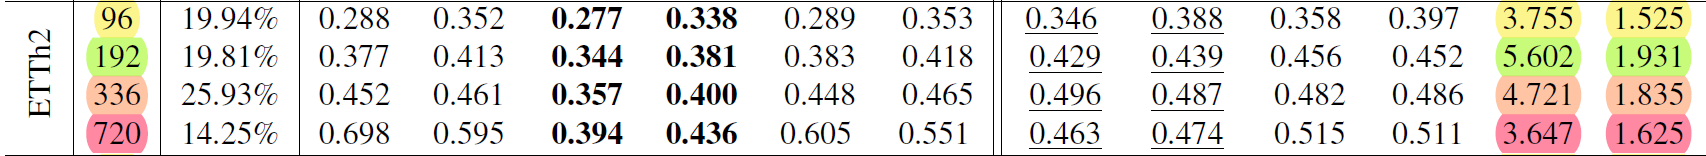

In [1]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTh2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 2.4837021827697754 | 1.15531587600708 |
| 192 | 3.5453412532806396 | 1.6633073091506958 |
| 336 | 2.984318494796753 | 1.3787071704864502 |
| 720 | 3.013077735900879 | 1.4968270063400269 |

---
# Working on ETTm1 Dataset
---

## Trail 1: Informer, Dataset:ETTm1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [36]:
args.data = 'ETTm1'            # dataset name
args.data_path = 'ETTm1.csv'   # data file
args.pred_len = 96

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_96:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [37]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11425
test 11425
	iters: 100, epoch: 1 | loss: 0.7313402
	speed: 0.4759s/iter; left time: 2997.0409s
	iters: 200, epoch: 1 | loss: 0.7392831
	speed: 0.4671s/iter; left time: 2894.7514s
	iters: 300, epoch: 1 | loss: 0.6794568
	speed: 0.4229s/iter; left time: 2578.2704s
	iters: 400, epoch: 1 | loss: 0.5761884
	speed: 0.4311s/iter; left time: 2585.1139s
	iters: 500, epoch: 1 | loss: 0.4987201
	speed: 0.4400s/iter; left time: 2594.8342s
	iters: 600, epoch: 1 | loss: 0.4276369
	speed: 0.4388s/iter; left time: 2543.7299s
	iters: 700, epoch: 1 | loss: 0.4315258
	speed: 0.4290s/iter; left time: 2444.2625s
	iters: 800, epoch: 1 | loss: 0.4988608
	speed: 0.4631s/iter; left time: 2591.9711s
	iters: 900, epoch: 1 | loss: 0.4401419
	speed: 0.4719s/iter; left time: 2594.1131s
	iters: 1000, epoch: 1 | loss: 0.4795313
	speed: 0.4791s/iter; left time: 2585.7479s
Epoch: 1 cost time: 483.9864149093628
Epoch: 1, Steps: 1066 | Train Loss: 0.6156512 Vali Loss: 1.2644562 Test 

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [38]:
exp.test(setting)
torch.cuda.empty_cache()

test 11425
test shape: (357, 32, 96, 7) (357, 32, 96, 7)
test shape: (11424, 96, 7) (11424, 96, 7)
mse:1.3085814714431763, mae:0.9307424426078796


---
## Trail 2: Informer, Dataset:ETTm1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [39]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_192:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [40]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34033
val 11329
test 11329
	iters: 100, epoch: 1 | loss: 0.6825605
	speed: 1.0240s/iter; left time: 6429.7879s
	iters: 200, epoch: 1 | loss: 0.7389103
	speed: 1.0049s/iter; left time: 6209.3487s
	iters: 300, epoch: 1 | loss: 0.6039448
	speed: 0.9630s/iter; left time: 5854.1901s
	iters: 400, epoch: 1 | loss: 0.5653376
	speed: 0.9040s/iter; left time: 5405.1325s
	iters: 500, epoch: 1 | loss: 0.4663773
	speed: 0.8809s/iter; left time: 5179.0517s
	iters: 600, epoch: 1 | loss: 0.4771079
	speed: 0.9071s/iter; left time: 5242.0070s
	iters: 700, epoch: 1 | loss: 0.4545580
	speed: 0.9160s/iter; left time: 5202.1293s
	iters: 800, epoch: 1 | loss: 0.4916990
	speed: 1.0009s/iter; left time: 5583.9500s
	iters: 900, epoch: 1 | loss: 0.5615091
	speed: 0.9950s/iter; left time: 5451.7236s
	iters: 1000, epoch: 1 | loss: 0.4785345
	speed: 0.9971s/iter; left time: 5363.2310s
Epoch: 1 cost time: 1023.1969690322876
Epoch: 1, Steps: 1063 | Train Loss: 0.6226956 Vali Loss: 1.5692221 Test

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [41]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 11329
test shape: (354, 32, 192, 7) (354, 32, 192, 7)
test shape: (11328, 192, 7) (11328, 192, 7)
mse:1.4236183166503906, mae:0.9478102326393127


---
## Trail 3: Informer, Dataset:ETTm1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [42]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_336:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [43]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33889
val 11185
test 11185
	iters: 100, epoch: 1 | loss: 0.8638499
	speed: 1.1679s/iter; left time: 7305.3368s
	iters: 200, epoch: 1 | loss: 0.6264448
	speed: 1.1912s/iter; left time: 7331.7259s
	iters: 300, epoch: 1 | loss: 0.6853592
	speed: 1.1739s/iter; left time: 7107.9245s
	iters: 400, epoch: 1 | loss: 0.5525738
	speed: 1.1800s/iter; left time: 7026.9579s
	iters: 500, epoch: 1 | loss: 0.6258067
	speed: 1.1791s/iter; left time: 6903.4249s
	iters: 600, epoch: 1 | loss: 0.5194860
	speed: 1.1719s/iter; left time: 6744.3320s
	iters: 700, epoch: 1 | loss: 0.5585417
	speed: 1.1820s/iter; left time: 6684.3215s
	iters: 800, epoch: 1 | loss: 0.5954760
	speed: 1.1771s/iter; left time: 6538.8700s
	iters: 900, epoch: 1 | loss: 0.6073945
	speed: 1.1790s/iter; left time: 6431.2184s
	iters: 1000, epoch: 1 | loss: 0.5065300
	speed: 1.1688s/iter; left time: 6259.1378s
Epoch: 1 cost time: 1245.795269727707
Epoch: 1, Steps: 1059 | Train Loss: 0.6939167 Vali Loss: 1.5681908 Test 

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [44]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 11185
test shape: (349, 32, 336, 7) (349, 32, 336, 7)
test shape: (11168, 336, 7) (11168, 336, 7)
mse:1.3351807594299316, mae:0.9173144698143005


---
## Trail 4: Informer, Dataset:ETTm1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [45]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_720:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 336, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [46]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33505
val 10801
test 10801
	iters: 100, epoch: 1 | loss: 0.9469267
	speed: 0.1448s/iter; left time: 895.3027s
	iters: 200, epoch: 1 | loss: 0.6830285
	speed: 0.1473s/iter; left time: 896.0802s
	iters: 300, epoch: 1 | loss: 0.5960441
	speed: 0.1639s/iter; left time: 980.8285s
	iters: 400, epoch: 1 | loss: 0.7091423
	speed: 0.1459s/iter; left time: 858.5493s
	iters: 500, epoch: 1 | loss: 0.6357602
	speed: 0.1477s/iter; left time: 854.2467s
	iters: 600, epoch: 1 | loss: 0.6556748
	speed: 0.1403s/iter; left time: 797.0728s
	iters: 700, epoch: 1 | loss: 0.6134006
	speed: 0.1367s/iter; left time: 763.2781s
	iters: 800, epoch: 1 | loss: 0.5689014
	speed: 0.1563s/iter; left time: 857.0511s
	iters: 900, epoch: 1 | loss: 0.6309907
	speed: 0.1498s/iter; left time: 806.2680s
	iters: 1000, epoch: 1 | loss: 0.5923913
	speed: 0.1460s/iter; left time: 771.1186s
Epoch: 1 cost time: 154.42730331420898
Epoch: 1, Steps: 1047 | Train Loss: 0.7104201 Vali Loss: 1.5934916 Test Loss: 1.3

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [47]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 10801
test shape: (337, 32, 720, 7) (337, 32, 720, 7)
test shape: (10784, 720, 7) (10784, 720, 7)
mse:1.3433761596679688, mae:0.947953999042511


---
## Compare Results of `ETTm1`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

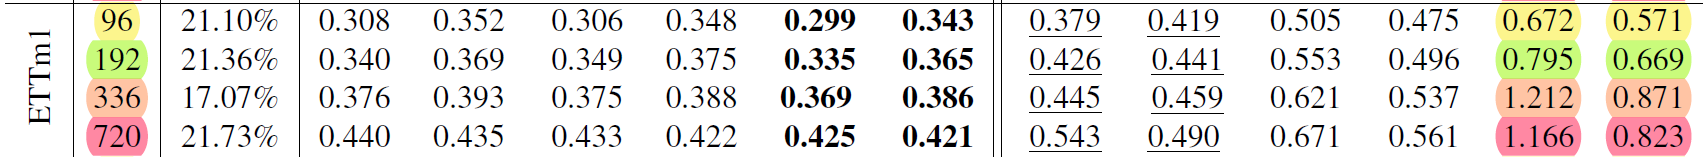

In [14]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTm1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 1.3374640941619873 | 0.9618014693260193 |
| 192 | 1.2347673177719116 | 0.8905289173126221 |
| 336 | 1.1492547988891602 | 0.8315280079841614 |
| 720 | 1.132256031036377 | 0.8511157035827637 |

---
# Working on ETTm2 Dataset
---

## Trail 1: Informer, Dataset:ETTm2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [48]:
args.data = 'ETTm2'            # dataset name
args.data_path = 'ETTm2.csv'   # data file
args.seq_len = 96

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_720:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 96, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [49]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters: 100, epoch: 1 | loss: 0.7926679
	speed: 0.1188s/iter; left time: 739.3994s
	iters: 200, epoch: 1 | loss: 0.5977684
	speed: 0.1214s/iter; left time: 743.3490s
	iters: 300, epoch: 1 | loss: 0.4614437
	speed: 0.1206s/iter; left time: 726.8886s
	iters: 400, epoch: 1 | loss: 0.5025269
	speed: 0.1186s/iter; left time: 702.6574s
	iters: 500, epoch: 1 | loss: 0.6287920
	speed: 0.1144s/iter; left time: 666.5848s
	iters: 600, epoch: 1 | loss: 0.7013958
	speed: 0.1153s/iter; left time: 659.8820s
	iters: 700, epoch: 1 | loss: 1.1575184
	speed: 0.1187s/iter; left time: 667.7247s
	iters: 800, epoch: 1 | loss: 0.5701699
	speed: 0.1106s/iter; left time: 611.1074s
	iters: 900, epoch: 1 | loss: 0.6793662
	speed: 0.1214s/iter; left time: 658.5534s
	iters: 1000, epoch: 1 | loss: 0.6763350
	speed: 0.1130s/iter; left time: 601.7090s
Epoch: 1 cost time: 124.19923281669617
Epoch: 1, Steps: 1054 | Train Loss: 0.7506016 Vali Loss: 2.7725163 Test Loss: 4.0

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [50]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 10801
test shape: (337, 32, 720, 7) (337, 32, 720, 7)
test shape: (10784, 720, 7) (10784, 720, 7)
mse:2.346555233001709, mae:1.2665212154388428


---
## Trail 2: Informer, Dataset:ETTm2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [51]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_192:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 96, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [52]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34273
val 11329
test 11329
	iters: 100, epoch: 1 | loss: 0.6489193
	speed: 0.1125s/iter; left time: 711.5055s
	iters: 200, epoch: 1 | loss: 0.6470139
	speed: 0.1170s/iter; left time: 728.3399s
	iters: 300, epoch: 1 | loss: 0.3810942
	speed: 0.1241s/iter; left time: 760.1455s
	iters: 400, epoch: 1 | loss: 0.6210093
	speed: 0.1229s/iter; left time: 740.4696s
	iters: 500, epoch: 1 | loss: 0.3700991
	speed: 0.1143s/iter; left time: 677.7167s
	iters: 600, epoch: 1 | loss: 0.2946611
	speed: 0.1166s/iter; left time: 679.1960s
	iters: 700, epoch: 1 | loss: 0.2629346
	speed: 0.1145s/iter; left time: 655.7049s
	iters: 800, epoch: 1 | loss: 0.4912150
	speed: 0.1189s/iter; left time: 669.1773s
	iters: 900, epoch: 1 | loss: 0.4060704
	speed: 0.1218s/iter; left time: 673.4116s
	iters: 1000, epoch: 1 | loss: 0.6790302
	speed: 0.1167s/iter; left time: 633.5668s
Epoch: 1 cost time: 126.35141038894653
Epoch: 1, Steps: 1071 | Train Loss: 0.5916986 Vali Loss: 1.4090847 Test Loss: 2.8

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [53]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 11329
test shape: (354, 32, 192, 7) (354, 32, 192, 7)
test shape: (11328, 192, 7) (11328, 192, 7)
mse:2.2090108394622803, mae:1.192978858947754


---
## Trail 3: Informer, Dataset:ETTm2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [54]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_336:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 96, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [55]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11185
test 11185
	iters: 100, epoch: 1 | loss: 0.9432096
	speed: 0.1150s/iter; left time: 724.1853s
	iters: 200, epoch: 1 | loss: 0.6724907
	speed: 0.1131s/iter; left time: 700.7436s
	iters: 300, epoch: 1 | loss: 0.8574768
	speed: 0.1222s/iter; left time: 744.8147s
	iters: 400, epoch: 1 | loss: 0.5673898
	speed: 0.1181s/iter; left time: 708.3938s
	iters: 500, epoch: 1 | loss: 0.8943440
	speed: 0.1144s/iter; left time: 674.7770s
	iters: 600, epoch: 1 | loss: 0.8757358
	speed: 0.1320s/iter; left time: 765.3229s
	iters: 700, epoch: 1 | loss: 0.7166607
	speed: 0.1264s/iter; left time: 720.0862s
	iters: 800, epoch: 1 | loss: 0.6249446
	speed: 0.1221s/iter; left time: 683.4540s
	iters: 900, epoch: 1 | loss: 0.8930020
	speed: 0.1149s/iter; left time: 631.7396s
	iters: 1000, epoch: 1 | loss: 0.5236042
	speed: 0.1188s/iter; left time: 641.1031s
Epoch: 1 cost time: 127.82349181175232
Epoch: 1, Steps: 1066 | Train Loss: 0.8085249 Vali Loss: 1.2101711 Test Loss: 2.3

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [56]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 11185
test shape: (349, 32, 336, 7) (349, 32, 336, 7)
test shape: (11168, 336, 7) (11168, 336, 7)
mse:2.3842663764953613, mae:1.2582660913467407


---
## Trail 4: Informer, Dataset:ETTm2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [57]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_720:

{'train_only': True, 'model': 'informer', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/Informer_checkpoints', 'patience': 3, 'train_epochs': 6, 'freq': 'h', 'seq_len': 96, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [58]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters: 100, epoch: 1 | loss: 0.6170563
	speed: 0.1160s/iter; left time: 722.2790s
	iters: 200, epoch: 1 | loss: 0.7893506
	speed: 0.1144s/iter; left time: 700.8030s
	iters: 300, epoch: 1 | loss: 0.4874583
	speed: 0.1216s/iter; left time: 732.4929s
	iters: 400, epoch: 1 | loss: 0.3705328
	speed: 0.1330s/iter; left time: 788.2856s
	iters: 500, epoch: 1 | loss: 0.7591282
	speed: 0.1229s/iter; left time: 716.0524s
	iters: 600, epoch: 1 | loss: 0.4186920
	speed: 0.1175s/iter; left time: 672.5570s
	iters: 700, epoch: 1 | loss: 0.4407893
	speed: 0.1256s/iter; left time: 706.3476s
	iters: 800, epoch: 1 | loss: 0.3955094
	speed: 0.1160s/iter; left time: 640.6266s
	iters: 900, epoch: 1 | loss: 0.4178562
	speed: 0.1270s/iter; left time: 689.2313s
	iters: 1000, epoch: 1 | loss: 0.4068364
	speed: 0.1170s/iter; left time: 622.8171s
Epoch: 1 cost time: 127.42822551727295
Epoch: 1, Steps: 1054 | Train Loss: 0.5951130 Vali Loss: 1.6882063 Test Loss: 6.6

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

### Testing

In [59]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

test 10801
test shape: (337, 32, 720, 7) (337, 32, 720, 7)
test shape: (10784, 720, 7) (10784, 720, 7)
mse:6.631315231323242, mae:2.331737756729126


---
## Compare Results of `ETTm2`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

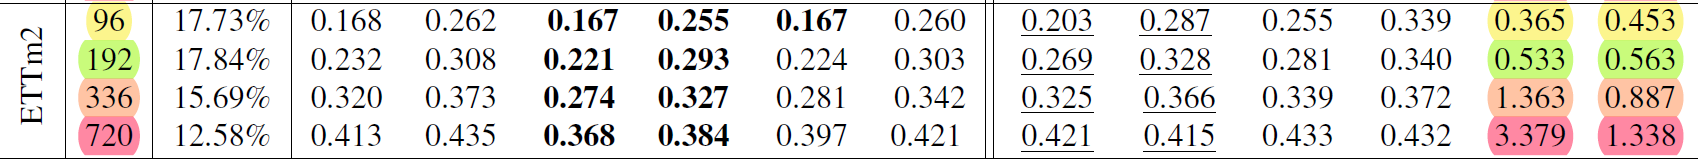

In [15]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTm2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 3.426589250564575 | 1.6164441108703613 |
| 192 | 2.4573633670806885 | 1.2444374561309814 |
| 336 | 2.320659875869751 | 1.1376394033432007 |
| 720 | 3.672842502593994 | 1.5754497051239014 |
